## Quadrotor Maze with Visualization

In [1]:
using TrajectoryOptimization
using Plots, LinearAlgebra, MeshCat, GeometryTypes, CoordinateTransformations, FileIO, MeshIO

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/c443b012d0ad3ce8e6cc9de306cd3766b1d18a79-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/c443b012d0ad3ce8e6cc9de306cd3766b1d18a79-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

Import the quadrotor model

In [46]:
model = Dynamics.quadrotor_model
n = model.n # number of states
m = model.m; # number of controls

Define numerical type

In [47]:
T = Float64;

Define initial and goals states

In [48]:
q0 = [1.;0.;0.;0.] # unit quaternion

x0 = zeros(T,n)
x0[1:3] = [0.; 0.; 10.]
x0[4:7] = q0

xf = zero(x0)
xf[1:3] = [0.;60.; 10.]
xf[4:7] = q0;

Define a cost function, e.g., quadratic

In [49]:
Q = (5.0)*Diagonal(I,n)
R = (5.0)*Diagonal(I,m)
Qf = 1000.0*Diagonal(I,n)
cost = LQRCost(Q, R, Qf, xf);

Define constraints

In [50]:
r_quad = 3.0
r_cylinder = 2.
cylinders = []
zh = 3
l1 = 5
l2 = 4
l3 = 10
l4 = 10

push!(cylinders,(0,30,r_cylinder))
push!(cylinders,(-2,30,r_cylinder))
push!(cylinders,(2,30,r_cylinder))
# push!(cylinders,(-3,30,r_cylinder))

# push!(cylinders,(3,30,r_cylinder))
# push!(cylinders,(6,30,r_cylinder))


for i = range(-25,stop=-10,length=l1)
    push!(cylinders,(i, 10,r_cylinder))
end

for i = range(10,stop=25,length=l1)
    push!(cylinders,(i, 10, r_cylinder))
end

# for i = range(-7.5,stop=7.5,length=l3)
#     push!(cylinders,(i, 30, r_cylinder))
# end

for i = range(-25,stop=-10,length=l1)
    push!(cylinders,(i, 50, r_cylinder))
end

for i = range(10,stop=25,length=l1)
    push!(cylinders,(i, 50, r_cylinder))
end

for i = range(10+2*r_cylinder,stop=50-2*r_cylinder,length=l4)
    push!(cylinders,(-25, i, r_cylinder))
end

for i = range(10+2*r_cylinder,stop=50-2*r_cylinder,length=l4)
    push!(cylinders,(25, i, r_cylinder))
end

n_cylinders = length(cylinders)

function cI_maze(c,x,u)
    for i = 1:n_cylinders
        c[i] = circle_constraint(x,cylinders[i][1],cylinders[i][2],cylinders[i][3]+r_quad)
    end
    c
end

maze = Constraint{Inequality}(cI_maze,n,m,n_cylinders,:maze)

u_min = 0.
u_max = 20.
x_max = Inf*ones(model.n)
x_min = -Inf*ones(model.n)

x_max[1:3] = [25.0; Inf; 20]
x_min[1:3] = [-25.0; -Inf; 0.]
bnd = BoundConstraint(n,m,u_min=u_min,u_max=u_max,x_min=x_min,x_max=x_max,trim=true)

goal = goal_constraint(xf)
con = [bnd,maze,goal]; # constraint set

Solver options

In [51]:
verbose=false
opts_ilqr = iLQRSolverOptions{T}(verbose=true,iterations=150,live_plotting=:off)

opts_al = AugmentedLagrangianSolverOptions{T}(verbose=true,opts_uncon=opts_ilqr,
    iterations=10,cost_tolerance=1.0e-4,cost_tolerance_intermediate=1.0e-4,constraint_tolerance=1.0e-3,penalty_scaling=10.,penalty_initial=100.)

opts_altro = ALTROSolverOptions{T}(verbose=true,resolve_feasible_problem=false,opts_al=opts_al,R_inf=1.0);

Define a problem

In [52]:
N = 101 # number of knot points
tf = 5.0
dt = tf/(N-1) # total time

U = [0.5*9.81/4.0*ones(m) for k = 1:N-1] # initial hovering control trajectory
obj = Objective(cost,N) # objective with same stagewise costs

con_set = ProblemConstraints(con,N) # constraint trajectory

prob = Problem(model,obj, constraints=con_set, x0=x0, integration=:rk4, N=N, dt=dt)
initial_controls!(prob,U); # initialize problem with controls

State trajectory guess

In [53]:
X_guess = zeros(n,7)
X_guess[:,1] = x0
X_guess[:,7] = xf
X_guess[1:3,2:6] .= [0 -12.5 -20 -12.5 0 ;15 20 30 40 45 ;10 10 10 10 10]

X_guess[4:7,:] .= q0
X0 = TrajectoryOptimization.interp_rows(N,tf,X_guess);

Solve problem

In [45]:
solve!(prob, ALTROSolverOptions{T}(verbose=true))

┌ Info: Infeasible Solve
└ @ TrajectoryOptimization /home/taylor/.julia/dev/TrajectoryOptimization/src/altro.jl:61


DimensionMismatch: DimensionMismatch("tried to assign 17 elements to 4 destinations")

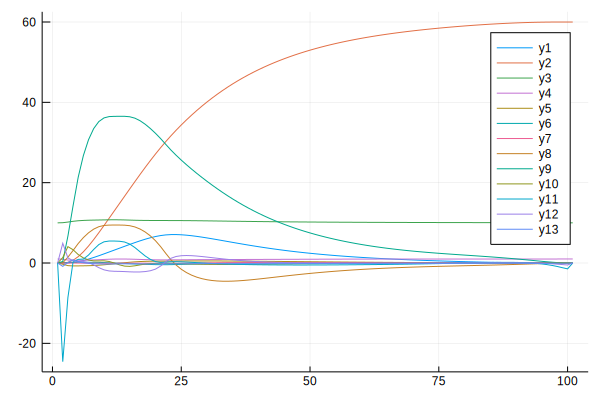

In [39]:
# pos = [prob.X[k][1:3] for k = 1:N]
# plot(pos)
# Xguess = copy(prob.X)
plot(Xguess)

Visualization

In [12]:
vis = Visualizer()
# open(vis)
IJuliaCell(vis)

WebIO.Scope("scope-29bfe614-176b-4b5a-b9c0-cf3a9cc1e44c", WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{DOM}(DOM(:html, :iframe), Any[], Dict{Symbol,Any}(:attributes=>Dict{String,Any}("height"=>"100%","scrolling"=>"no","src"=>"javascript:void(0)","frameborder"=>0),:id=>"ifr",:style=>Dict("width"=>"100%","flexGrow"=>"1")), 0)], Dict{Symbol,Any}(:style=>Dict("flexDirection"=>"column","height"=>"100%","minHeight"=>"400px","display"=>"flex","width"=>"100%","overflow"=>"hidden")), 1), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}(), Set(String[]), nothing, Any[], Dict{Any,Any}("_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function () {\n    var frame = this.dom.querySelector(\"#ifr\");\n    var doc = frame.contentDocument\n    var win = frame.contentWindow\n\n    // Ensure that the iframe's baseURI matches the baseURI of the\n    // outer document. This is necessary to resolve\n    // https://github.com/JuliaGizmos/WebIO.jl/issues/167\n    var base = doc.createElement(\"base\");\n    base.setAttribute(\"href\", document.baseURI);\n    doc.head.appendChild(base);\n\n    var webio = doc.createElement(\"script\")\n    webio.src = \"/assetserver/c443b012d0ad3ce8e6cc9de306cd3766b1d18a79-assets/webio/dist/bundle.js\"\n    var parent = window\n\n    function resizeIframe() {\n        doc.body.style.padding = '0'\n        doc.body.style.margin = '0'\n        doc.documentElement.height = '100%'\n        doc.body.height = '100%'\n    }\n\n    webio.onload = function () {\n        win.WebIO.sendCallback = parent.WebIO.sendCallback; // Share stuff\n        win.WebIO.scopes = parent.WebIO.scopes\n        win.WebIO.obsscopes = parent.WebIO.obsscopes\n        win.WebIO._connected = true\n        doc.body.innerHTML = \"<html><body>\" + \"<div class='display:none'></div><unsafe-script style='display:none'>\\nWebIO.mount(this.previousSibling,{&quot;props&quot;:{},&quot;nodeType&quot;:&quot;Scope&quot;,&quot;type&quot;:&quot;node&quot;,&quot;instanceArgs&quot;:{&quot;imports&quot;:{&quot;data&quot;:[{&quot;name&quot;:null,&quot;type&quot;:&quot;js&quot;,&quot;url&quot;:&quot;/assetserver/39091d6b9eb892b592bedf9cea6c288f61f7d3f3-main.min.js&quot;}],&quot;type&quot;:&quot;async_block&quot;},&quot;id&quot;:&quot;scope-811fcc65-140e-41b1-ba7b-07809c0b1f5c&quot;,&quot;handlers&quot;:{&quot;meshcat-command&quot;:[(function (val){return this.viewer.handle_command_message({&quot;data&quot;:val})})],&quot;_promises&quot;:{&quot;importsLoaded&quot;:[(function (mc){var element=this.dom.children[0]; this.viewer=new mc.Viewer(element); WebIO.setval({&quot;name&quot;:&quot;meshcat-request&quot;,&quot;scope&quot;:&quot;scope-811fcc65-140e-41b1-ba7b-07809c0b1f5c&quot;,&quot;id&quot;:&quot;ob_02&quot;,&quot;type&quot;:&quot;observable&quot;},String(Date.now())); window.document.body.style.margin=&quot;0&quot;; return window.meshcat_viewer=this.viewer})]}},&quot;systemjs_options&quot;:null,&quot;observables&quot;:{&quot;meshcat-command&quot;:{&quot;sync&quot;:false,&quot;id&quot;:&quot;ob_01&quot;,&quot;value&quot;:[]},&quot;meshcat-controls&quot;:{&quot;sync&quot;:true,&quot;id&quot;:&quot;ob_03&quot;,&quot;value&quot;:[]},&quot;meshcat-request&quot;:{&quot;sync&quot;:true,&quot;id&quot;:&quot;ob_02&quot;,&quot;value&quot;:&quot;&quot;}}},&quot;children&quot;:[{&quot;props&quot;:{&quot;className&quot;:&quot;meshcat-viewer&quot;,&quot;style&quot;:{&quot;left&quot;:0,&quot;right&quot;:0,&quot;overflow&quot;:&quot;hidden&quot;,&quot;position&quot;:&quot;absolute&quot;,&quot;height&quot;:&quot;100vh&quot;,&quot;margin&quot;:0,&quot;width&quot;:&quot;100vw&quot;}},&quot;nodeType&quot;:&quot;DOM&quot;,&quot;type&quot;:&quot;node&quot;,&quot;instanceArgs&quot;:{&quot;namespace&quot;:&quot;html&quot;,&quot;tag&quot;:&quot;div&quot;},&quot;children&quot;:[]}]})</unsafe-script>\" + \"</body></html>\";\n        setTimeout(function () { resizeIframe() }, 0)\n    }\n\n    doc.body.appendChild(webio)\n}"), JSString("(function (){retur

Colors

In [13]:
green_ = MeshPhongMaterial(color=RGBA(0, 1, 0, 1.0))
green_transparent = MeshPhongMaterial(color=RGBA(0, 1, 0, 0.1))
red_ = MeshPhongMaterial(color=RGBA(1, 0, 0, 1.0))
red_transparent = MeshPhongMaterial(color=RGBA(1, 0, 0, 0.1))
blue_ = MeshPhongMaterial(color=RGBA(0, 0, 1, 1.0))
blue_transparent = MeshPhongMaterial(color=RGBA(0, 0, 1, 0.1))
blue_semi = MeshPhongMaterial(color=RGBA(0, 0, 1, 0.5))
yellow_ = MeshPhongMaterial(color=RGBA(1, 1, 0, 1.0))
yellow_transparent = MeshPhongMaterial(color=RGBA(1, 1, 0, 0.75))

orange_ = MeshPhongMaterial(color=RGBA(233/255, 164/255, 16/255, 1.0))
orange_transparent = MeshPhongMaterial(color=RGBA(233/255, 164/255, 16/255, 0.1))
black_ = MeshPhongMaterial(color=RGBA(0, 0, 0, 1.0))
black_transparent = MeshPhongMaterial(color=RGBA(0, 0, 0, 0.1))
black_semi = MeshPhongMaterial(color=RGBA(0, 0, 0, 0.5));

In [14]:
function plot_cylinder(c1,c2,radius,mat,name="")
    geom = Cylinder(Point3f0(c1),Point3f0(c2),convert(Float32,radius))
    setobject!(vis["cyl"][name],geom,red_)
end

function addcylinders!(vis,cylinders,height=1.5)
    for (i,cyl) in enumerate(cylinders)
        plot_cylinder([cyl[1],cyl[2],0],[cyl[1],cyl[2],height],cyl[3],blue_,"cyl_$i")
        # plot_cylinder([cyl[1],cyl[2],0],[0,0,height],cyl[3],blue_,"cyl_$i")
    end
end

addcylinders! (generic function with 2 methods)

In [15]:
traj_folder = joinpath(dirname(pathof(TrajectoryOptimization)),"..")
urdf_folder = joinpath(traj_folder, "dynamics","urdf")
obj = joinpath(urdf_folder, "quadrotor_base.obj")

robot_obj = FileIO.load(obj);

In [16]:
sphere_small = HyperSphere(Point3f0(0), convert(Float32,0.1*r_quad)) # trajectory points
sphere_medium = HyperSphere(Point3f0(0), convert(Float32,0.25*r_quad));

In [17]:
obstacles = vis["obs"]
traj = vis["traj"]
robot = vis["robot"]
setobject!(vis["robot"]["quad"],robot_obj,black_);

In [18]:
settransform!(vis["/Cameras/default"], compose(Translation(0., 72., 60.),LinearMap(RotX(pi/7.5)*RotZ(pi/2))))

MeshCat Visualizer with path /Cameras/default

In [19]:
addcylinders!(vis,cylinders,16.0)

In [20]:
traj = vis["traj"]

for i = 1:N
    setobject!(vis["traj"]["t$i"],sphere_small,blue_)
    settransform!(vis["traj"]["t$i"], Translation(prob.X[i][1], prob.X[i][2], prob.X[i][3]))
end

In [21]:
anim = MeshCat.Animation(20)
for i = 1:N
    MeshCat.atframe(anim,vis,i) do frame
        settransform!(frame["robot"], compose(Translation(prob.X[i][1:3]...),LinearMap(Quat(prob.X[i][4:7]...))))
    end
end
MeshCat.setanimation!(vis,anim)